# Chapter 6

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

In [65]:
# CausalGraphicalModels needs the following import, and alias
import collections.abc
collections.Iterable = collections.abc.Iterable

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

#### Code 6.1

In [5]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

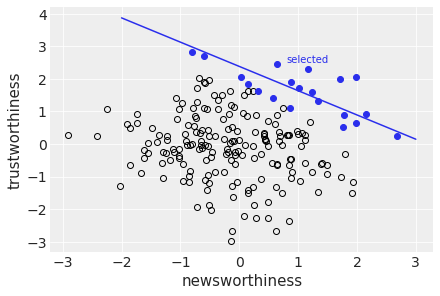

In [6]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

#### Code 6.2

In [13]:
np.random.seed(43)
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.514800,4.519797,4.501731
1,8.183037,3.724436,3.716354
2,9.242994,4.462500,4.461097
3,8.930169,4.091304,4.086514
4,11.716147,5.099324,5.127690


#### Code 6.3

In [17]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100) # the huge varriance implies almonst no prior information
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)
    # predict mean based on both leg lengths
    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    m_6_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 238 seconds.


In [19]:
az.summary(m_6_1_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.99,0.33,0.44,1.47,0.01,0.00,2422.89,2300.14,1.0
bl,1.18,2.32,-2.52,4.86,0.06,0.04,1443.48,1702.48,1.0
br,0.82,2.32,-3.10,4.27,0.06,0.04,1443.22,1674.38,1.0
sigma,0.65,0.05,0.57,0.72,0.00,0.00,2558.37,2185.81,1.0


#### Code 6.4

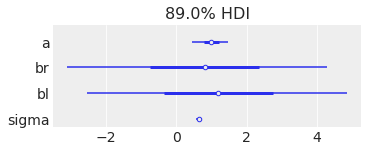

In [20]:
_ = az.plot_forest(m_6_1_trace, var_names=["a", "br", "bl", "sigma"], combined=True, figsize=[5, 2])

#### Code 6.5 & 6.6

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

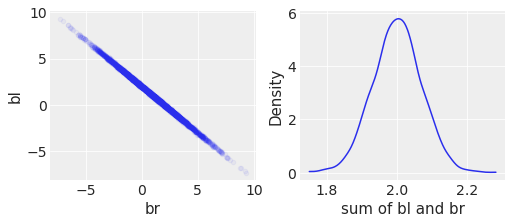

In [21]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

br_post = m_6_1_trace.posterior["br"].values
bl_post = m_6_1_trace.posterior["bl"].values

# code 6.5
ax1.scatter(br_post, bl_post, alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(br_post + bl_post, ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");

#### Code 6.7

In [22]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left.values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)

    m_6_2_trace = pm.sample()

az.summary(m_6_2_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8797, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.01,0.33,0.51,1.55,0.01,0.01,1282.97,1410.47,1.0
bl,2.00,0.07,1.88,2.11,0.00,0.00,1230.01,1399.93,1.0
sigma,0.64,0.05,0.57,0.71,0.00,0.00,1870.07,1815.74,1.0


#### Code 6.8

In [24]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### Code 6.9

In [25]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_3_trace = pm.sample()

az.summary(m_6_3_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.13,0.13,0.0,0.0,5070.73,2921.76,1.0
bF,0.86,0.09,0.71,1.00,0.0,0.0,4577.48,3032.26,1.0
sigma,0.49,0.07,0.38,0.59,0.0,0.0,3615.82,2467.05,1.0


In [26]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)

    mu = a + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_4_trace = pm.sample()

az.summary(m_6_4_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,-0.12,0.12,0.0,0.0,4358.96,2904.08,1.0
bF,-0.90,0.08,-1.03,-0.78,0.0,0.0,4608.29,3230.12,1.0
sigma,0.41,0.06,0.32,0.50,0.0,0.0,4032.95,3082.40,1.0


#### Code 6.10

In [27]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F.values + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_5_trace = pm.sample()

az.summary(m_6_5_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,-0.11,0.12,0.0,0.0,2701.33,2209.40,1.0
bF,0.26,0.20,-0.05,0.59,0.0,0.0,1670.61,1766.05,1.0
bL,-0.66,0.20,-0.99,-0.34,0.0,0.0,1676.35,1684.01,1.0
sigma,0.41,0.06,0.31,0.50,0.0,0.0,2474.58,2243.25,1.0


#### Code 6.11

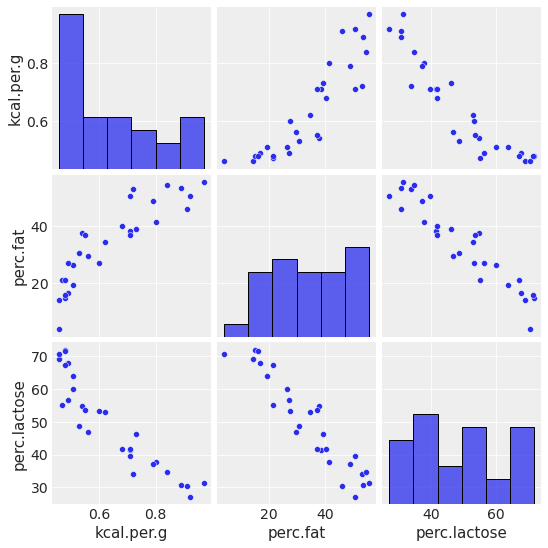

In [28]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

### Overthinking: Simulating collinearity.
The objective is to sumulate a situation where we have two distinct predictors that are correlated.  Moreover we would like to be able to varry the ammount of correlation there is between the two predictors.  We introduce a paramater, `r`, that will be used as the means of altering the degree of correlation.  We stay with our milk dataset, but introduce a synthetic predictor `x` that is constructed from the `perc.fat` predictor.  In our actual data we have 29 observations, so for each value of `r` we need to generate 29 observations `x` so that each syntetic observation is correlated with an actual observations where the strength of the correlation is dependent on `r`.  We generate the synthetic observations by drawing from a normal distribution $N(\mu, \sigma)$.  But which normal distribution.  If we let `r` range from 0 to 1, we can construct the distribution in such a way that when `r` is 0, the synthetic predictor is maximaly unrelated to our actual predictor, and when `r` is 1 the synthetic predictor is maximally correlated to our actual predictor.  One way to do that is to use actual observations from our data and scale them based on our parameter `r`, and to use the varriance of our actual data scaled by `1-r**2`.  Notice that when `r` is close to 1, $\sigma$ approaches 0 and hence the distribution that we are selecting synthetic values from will have the same standard deviation as our actual predictor with a mean value very close to the actual predictor and that when `r` is close to zero the distribution we are selecting synthetic values from will be very wide, with a mean value close to zero.

#### Code 6.12

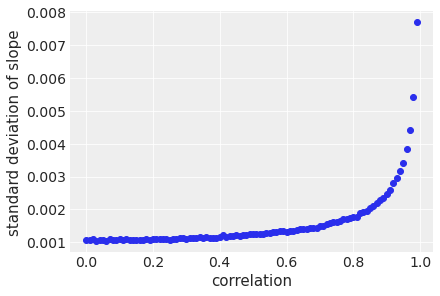

In [33]:
def mv(x, a, b, c):
    '''Define the linear model that we will be fitting.'''
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    # fit a linear model using d['perc.fat'] and our correlated predictor x
    # ordinary least squares is the same as maximum likelyhood for flat priors.
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    '''Return the mean of n runs of sim_coll(r)'''
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

#### Code 6.13

In [43]:
np.random.seed(43)
# number of plants (make sure it is even)
N = 2*50
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
# simulate the treatment efficacy.
# The plant has a 50% chance of developing fungus
# but if treated the chance drops to 10%. 
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
# having the fungus will reduce growth from 5 to 3  
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.13,1.93,7.03,13.32
h1,14.28,2.54,10.75,18.66
treatment,0.50,0.50,0.00,1.00
fungus,0.28,0.45,0.00,1.00


#### Code 6.14

In [44]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.61,1.41


#### Code 6.15

In [50]:
with pm.Model() as m_6_6:
    p = pm.LogNormal("p", 0, 0.25)
    # p is the proportion of growth 
    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
p,1.40,0.02,1.37,1.42
sigma,1.73,0.12,1.52,1.91


#### Code 6.16

In [49]:
with pm.Model() as m_6_7:
    a = pm.LogNormal("a", 0, 0.25)
    bT = pm.Normal("bT", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)

    p = a + bT * d.treatment.values + bF * d.fungus.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
bT,0.02,0.03,-0.02,0.06
bF,-0.26,0.03,-0.30,-0.21
a,1.45,0.02,1.42,1.49
sigma,1.21,0.09,1.07,1.34


#### Code 6.17

In [51]:
with pm.Model() as m_6_8:
    a = pm.LogNormal("a", 0, 0.2)
    bT = pm.Normal("bT", 0, 0.5)

    p = a + bT * d.treatment.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
bT,0.12,0.03,0.07,0.17
a,1.34,0.02,1.30,1.37
sigma,1.63,0.12,1.44,1.80


#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [53]:
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.inference import CausalInference

import warnings
warnings.filterwarnings('ignore')

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
plant_dag = BayesianModel([("H_0", "H_1"), ("F", "H_1"), ("T", "F")])

<Axes: >

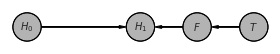

In [71]:
plant_dag.to_daft(node_pos={"H_0": (0,0), "H_1": (2,0), "F": (3,0), "T": (4,0)}).render()

In [73]:
plant_dag.all_independencies('H_0')

AttributeError: 'BayesianModel' object has no attribute 'all_independencies'

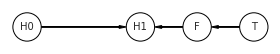

In [74]:
import daft

from causalgraphicalmodels import CausalGraphicalModel


def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()


plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}

draw_dag(plant_dag, coordinates)

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [75]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('H0', 'F', set())
('H0', 'T', set())
('H1', 'T', {'F'})


#### Code 6.20

In [76]:
np.random.seed(71)
N = 500*2
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # default probability of rbern() is 0.5
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.00,1.93,6.85,13.00
h1,16.52,2.65,12.38,20.78
treatment,0.50,0.50,0.00,1.00
fungus,0.50,0.50,0.00,1.00


Re-run m_6_6 and m_6_7 on this dataset.

Running `m_6_7` it looks like since `bF` is positive, that haviging fungus helps the plant.

In [78]:
with pm.Model() as m_6_7:
    a = pm.LogNormal("a", 0, 0.25)
    bT = pm.Normal("bT", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)

    p = a + bT * d.treatment.values + bF * d.fungus.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bT, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
bT,0.06,0.01,0.04,0.08
bF,0.13,0.01,0.11,0.15
a,1.53,0.01,1.51,1.56
sigma,2.10,0.05,2.02,2.17


And running `m_6_6` it also looks like it helps the plants.  Remember `p` is equvalent to `a` in `m_6_6`.

In [79]:
with pm.Model() as m_6_6:
    p = pm.LogNormal("p", 0, 0.25)
    # p is the proportion of growth 
    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8879, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%
p,1.63,0.01,1.62,1.64
sigma,2.18,0.05,2.10,2.25


In [98]:
popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
np.array(popn.loc[:, "married"].values, dtype="bool")[99]

False

#### Code 6.21

Including a python implementation of the sim_happiness function

In [99]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)
    # population data frame with 20 individuals and 65 observations per individual.  Each observation has
    # three indicators: age, happiness and marriage status
    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    # intialize age from 0 to 64
    # age = 0
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    # initialize mean happiness between -2 and 2.  does not change for each individual.
    # np.linspace(-2, 2, 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    # initialize marriage status as boolean with no marriage.
    # marriage = False
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        # decide if they marry
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry
    # move the newborn to the front of the array
    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [100]:
popn = sim_happiness(N_years=1000, seed=1977)

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(int)
# this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


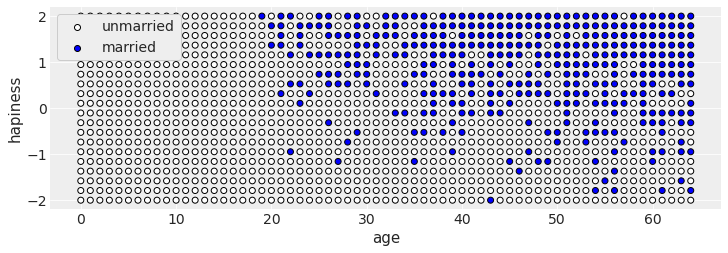

In [101]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

#### Code 6.22

In [102]:
adults = popn.loc[popn.age > 17].copy()
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

#### Code 6.23

In [103]:
mid = adults.loc[:, "married"].astype(int).values

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA *+ adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.06,-0.32,-0.12,0.0,0.0,1866.59,2153.22,1.0
a[1],1.27,0.09,1.13,1.41,0.0,0.0,1770.10,2079.36,1.0
bA,-0.71,0.12,-0.89,-0.52,0.0,0.0,1672.16,2069.64,1.0
sigma,1.00,0.02,0.96,1.03,0.0,0.0,3008.74,2764.45,1.0


#### Code 6.24

In [104]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.12,0.12,0.0,0.0,2412.15,2301.09,1.0
bA,-0.00,0.13,-0.22,0.21,0.0,0.0,2303.90,2436.47,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2269.86,2298.55,1.0


#### Code 6.25

In [106]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [107]:
# randomly assign neighbourhood effect as bernouli varriable.
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
# parents have grandparent effect + neighbourhood effect.
P = np.random.normal(b_GP * G + b_U * U)
# children are affected by all three
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

Text(0, 0.5, 'grandchild education (C)')

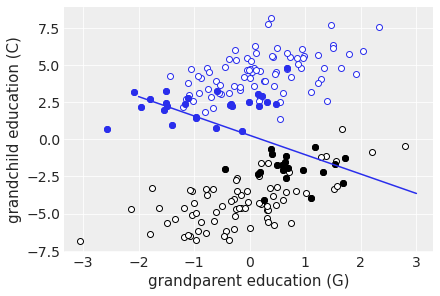

In [33]:
# Figure 6.5
# create selectors for stratifying our data
bad = U < 0
good = ~bad

# grandparent education
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")

# plot grandchild educational attainment vs grandparent educational attainment
# for cases where the parents educational attainment is close to the norm.
p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

#### Code 6.27

In [109]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    
    # we condition on P but not U
    mu = a + p_PC * d.P.values + p_GC * d.G.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_11_trace = pm.sample()

az.summary(m_6_11_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.09,-0.14,0.15,0.0,0.0,5247.23,3520.06,1.0
b_PC,1.79,0.04,1.73,1.86,0.0,0.0,3823.22,2781.44,1.0
b_GC,-0.80,0.10,-0.97,-0.63,0.0,0.0,3811.57,2849.96,1.0
sigma,1.30,0.07,1.19,1.40,0.0,0.0,6233.25,3230.36,1.0


#### Code 6.28

In [110]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    # now we add a prior for U
    p_U = pm.Normal("b_U", 0, 1)

    # and we condition on P as well as U.
    mu = a + p_PC * d.P.values + p_GC * d.G.values + p_U * d.U.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_12_trace = pm.sample()

az.summary(m_6_12_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, b_U, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.02,0.06,-0.08,0.13,0.0,0.0,3713.64,2883.65,1.0
b_PC,0.98,0.06,0.88,1.08,0.0,0.0,1352.93,1459.56,1.0
b_GC,0.05,0.09,-0.10,0.19,0.0,0.0,1622.31,2259.35,1.0
b_U,2.00,0.13,1.78,2.21,0.0,0.0,1372.22,1606.09,1.0
sigma,0.89,0.05,0.83,0.97,0.0,0.0,3851.83,2576.75,1.0


#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [111]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [112]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'M', 'A'})


#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [113]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'W', {'S'})
('W', 'A', {'S'})
('S', 'D', {'M', 'W', 'A'})


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w